<h1><center>Проверка гипотез по увеличению выручки в интернет-магазине — оценка результатов A/B теста</center></h1>

## Оглавление
* [Описание проекта](#first-bullet)
* [Описание данных](#second-bullet)
* [Шаг 1. Предобработка данных](#third-bullet)
* [Шаг 2. Приоритизация гипотез](#fourth-bullet)
* [Шаг 3. Анализ A/B-теста](#fifth-bullet)
* [Выводы](#sixth-bullet)

## Описание проекта <a class="anchor" id="first-bullet"></a>

Аналитическая работа в крупном интернет-магазине. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

## Описание данных <a class="anchor" id="second-bullet"></a>

#### Таблица hypothesis:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Таблица orders:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

##### Таблица visitors:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

## Шаг 1. Предобработка данных <a class="anchor" id="third-bullet"></a>

В файле hypothesis.csv - 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Необходимо:
- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

#### Импортируем все библиотеки, которые понадобятся в работе:

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

#### Ознакомимся с файлами:

In [2]:
hypothesis = pd.read_csv('hypothesis.csv', sep=',')
orders = pd.read_csv('orders.csv', sep=',')
visitors = pd.read_csv('visitors.csv', sep=',')

In [3]:
pd.options.display.max_colwidth = -1

In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице hypothesis единственное, что хочется исправить - это привести все названия столбцов к нижнему регистру для удобства их дальнейшего использования.


In [6]:
hypothesis.columns = map(str.lower, hypothesis.columns)
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [7]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблице visitors и в таблице orders заменим тип данных для столбцов date (дата посейщения и дата, когда был совершен заказ соответственно), сейчас они распознаются как тип object, но для дальнейших вчислений удобнее будет иметь тип datetime.

In [11]:
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Данные предобработаны, теперь можно перейти к применению фреймворков для приоритизации гипотез.

## Шаг 2. Приоритизация гипотез <a class="anchor" id="fourth-bullet"></a>

#### 2.1 Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

ICE рассчитывается по формуле: 

$$ICE = \frac{Impact * Confidence}{Efforts}$$

Фреймворк ICE состоит из трёх компонент:
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- Efforts — сколько стоит протестировать эту гипотезу.

Рассчитаем ICE для наших гипотез:

In [13]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

hypothesis_sorted = hypothesis[['hypothesis','ICE']]

hypothesis_sorted.sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Исходя из фрэймворка ICE, побеждают гипотезы 8-0-7-6-2.

#### 2.2 Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

RICE рассчитывается по формуле:

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$
    
Фреймворк RICE состоит из четырёх компонент:
- Reach — скольких пользователей затронет изменение, которое вы хотите внести;
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- Efforts — сколько стоит протестировать эту гипотезу.

In [14]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

hypothesis_sorted_new = hypothesis[['hypothesis','RICE']]

hypothesis_sorted_new.sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Исходя из фрэймворка RICE, побеждают те же гипотезы, что и в фрэймворке ICE, но приоритет уже другой: 7-2-0-6-8 (потому, что параметр reach у гипотез 7 и 2 - высокий (10 и 8 соответственно).

## Шаг 3. Анализ A/B-теста <a class="anchor" id="fifth-bullet"></a>

Результаты проведенных A/B-тестов хранятся в файлах orders.csv и visitors.csv.

Необходимо проанализировать A/B-тест:
- Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
- Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
- Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.
- Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.
- Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
- Посчитать точечный график стоимостей заказов. Сделать выводы и предположения.
- Посчитать 95-й и 99-й перцентили стоимости заказов. Сделать границу для определения аномальных заказов.
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
- Применить решение по результатам теста и объяснить его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

#### 3.1 Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

#### Таблица orders:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

#### Таблица visitors:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

In [15]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [16]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Cоздадим массив уникальных пар значений дат и групп A/B теста.


In [17]:
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получим агрегированные кумулятивные по дням данные о заказах.

In [18]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Получим агрегированные кумулятивные по дням данные о посетителях.


In [19]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим кумулятивные данные в одной таблице.

In [20]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и другой в группе B.


In [21]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

И наконец построим графики кумулятивной выручки по группам.

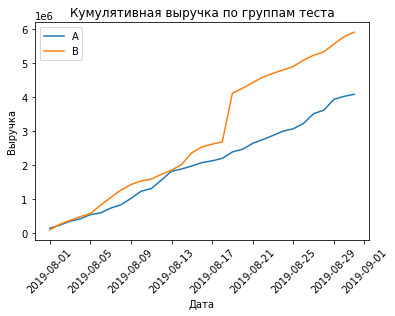

In [22]:
# График выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');

# График выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');

plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам теста')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend()
plt.show()

Из графика видно, что в группе А кумулятивная выручка растет достаточно плавно (хотя есть небольшие всплески иногда), а вот в группе B есть довольно большой скачок графика - это может говорить о резком росте числа заказов или о наличии очень дорогих заказов в эти даты.

#### 3. 2 Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

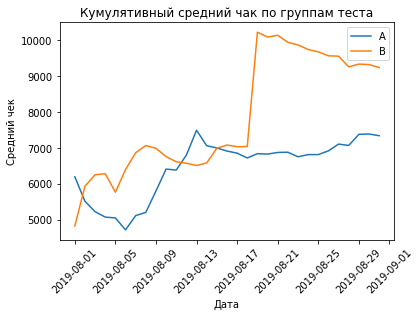

In [23]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.xticks(rotation=45)
plt.title('Кумулятивный средний чак по группам теста')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()

Из графика видно, что средний чек в обоих группах довольно сильно скачет (то увеличивается, то уменьшается). И если для группы A мы наблюдаем, что он более-менее установился во второй половине теста, то для группы B мы опять видим резкий скачок, который мы уже наблюдали на графике кумулятивной выручки. Что опять же может говорить о резком росте числа заказов или о наличии очень дорогих заказов в эти даты.

#### 3.3 Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.


Text(0.5, 0, 'Дата')

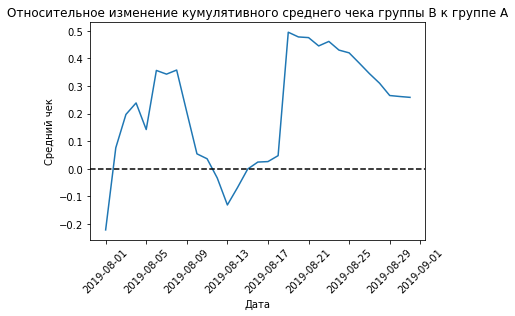

In [24]:
# собирем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# поcтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавим горизонтальную ось методом axhline()
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.ylabel('Средний чек')
plt.xlabel('Дата')

Опять видим, что в середине теста график скачет, это еще раз подтверждает теорию, что в данных есть выбросы.


#### 3.4 Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.

In [25]:
cumulativeData['date'].min()

Timestamp('2019-08-01 00:00:00')

In [26]:
cumulativeData['date'].max()

Timestamp('2019-08-31 00:00:00')

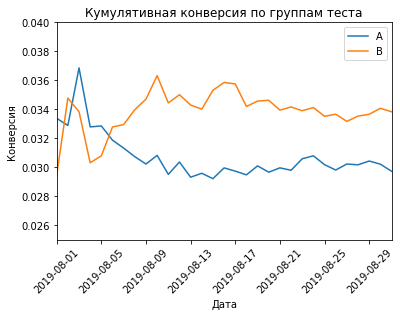

In [27]:
# посчитаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# выделим данные группы A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# выделим данные группы B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# построим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# зададим масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.04])

plt.xticks(rotation=45)
plt.title('Кумулятивная конверсия по группам теста')
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.legend()


Из графика видно, что сначала кумулятивная конверсия в обоих группах скачет, и где-то через 4-5 дней после начала теста конверсия в группе А сильно снижается, а после чего устанавливается на примерно одинаковых числах (3%), а конверсия группы B наоборот - резко скачет вверх и после этого тоже более-менее устанавливается (на 3,5%).

#### 3. 5 Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.

Text(0.5, 0, 'Дата')

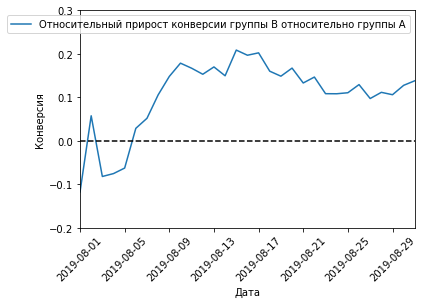

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.3])

plt.xticks(rotation=45)
plt.ylabel('Конверсия')
plt.xlabel('Дата')

Из графика видно, что в начале эксперимента выигрывала группа B, после чего мы наблюдаем резкий проигрыш в конверсии на несколько дней, но потом она опять растет и остается стабильно лучше относительно группы A на протяжении всего теста (хотя перепады все еще довольно сильные и нельзя сказать, что конверсия установилась).


#### 3.6 Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.


#### Таблица orders:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

#### Таблица visitors:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

Подсчитаем количество заказов по пользователям.

In [29]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['visitorId','orders']

print(ordersByUsers.sort_values(by='orders',ascending=False).head(15)) 

       visitorId  orders
1023  4256040402  11    
591   2458001652  11    
569   2378935119  9     
487   2038680547  8     
44    199603092   5     
744   3062433592  5     
55    237748145   5     
917   3803269165  5     
299   1230306981  5     
897   3717692402  5     
393   1614305549  4     
114   457167155   4     
619   2587333274  4     
340   1404934699  3     
937   3908431265  3     


Построим гистограму количества заказов по пользователям.

Text(0.5, 0, 'Кол-во заказов')

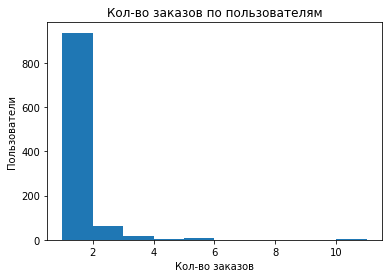

In [30]:
plt.hist(ordersByUsers['orders']) 

plt.title('Кол-во заказов по пользователям')
plt.ylabel('Пользователи')
plt.xlabel('Кол-во заказов')

Построим точечный график количества заказов по пользователям.

Text(0, 0.5, 'Кол-во заказов')

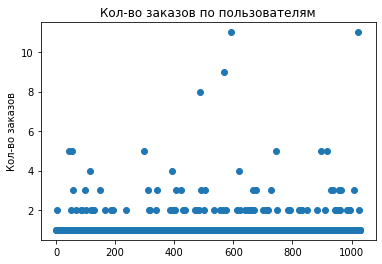

In [31]:
plt.scatter(x = ordersByUsers.index, y = ordersByUsers['orders']) 

plt.title('Кол-во заказов по пользователям')
plt.ylabel('Кол-во заказов')

Из гистограммы и точечного графика видно, что больше всего пользователей с 1-2-3 заказами, но также есть не нулевое, но сильно меньшее кол-во пользователей с 4-5 заказами, пользователей с большим кол-вом заказов скорее всего можно отнести к выбросам, тк они встречаются редко.

#### 3. 7 Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [32]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


То есть не более 5% пользователей оформляли больше чем 2 заказа. И лишь 1% пользователей заказывали больше 4 раза.

Поэтому возьмем 3 заказа за нижнюю границу и отсеим по ней аномальных пользователей.

#### 3.8 Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

Построим гистограму стоимостей заказов.

Text(0.5, 0, 'Стоимость заказов')

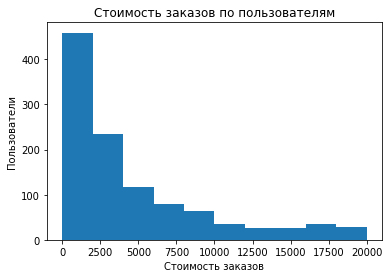

In [33]:
plt.hist(orders['revenue'], range = (0, 20000)) 

plt.title('Стоимость заказов по пользователям')
plt.ylabel('Пользователи')
plt.xlabel('Стоимость заказов')

Text(0.5, 0, 'Стоимость заказов')

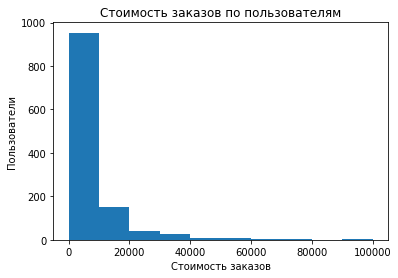

In [34]:
plt.hist(orders['revenue'], range = (0, 100000)) 
plt.title('Стоимость заказов по пользователям')
plt.ylabel('Пользователи')
plt.xlabel('Стоимость заказов')

Построим точечный график стоимостей заказов.

Text(0, 0.5, 'Стоимость заказов')

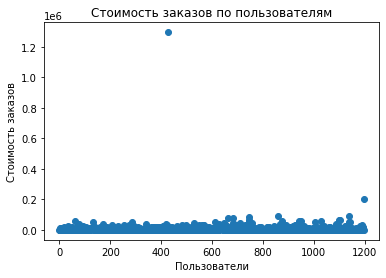

In [35]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.title('Стоимость заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')

Из гистограм и точечного графика видно, что не смотря на то, что есть заказы, стоимость которых больше 120 тысяч, большинство заказов все-таки находятся в пределах 20000 (из которых наибольший процент составляют заказы до 2500).

#### 3.9 Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [36]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


То есть 5% покупателей делали заказы более чем на 28000, и только 1% покупателей делали заказы на более чем 58233. 

Поэтому возьмем, например, стоимость заказа в 30000 за нижнюю границу и отсеим по ней аномальных пользователей.

#### 3.10 Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Сделаем выводы и предположения.

In [37]:
# Найдем количество пользователей в выбранную дату в группе A.

visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Найдем количество пользователей до выбранной даты включительно в группе A.
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# Те же два действия совершим для группы B.
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


# Найдем количество заказов и суммарную выручку в выбранную дату в группе A.
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#Также найдем суммарное число заказов и суммарную выручку до выбранной даты включительно в группе A.
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

# Тоже самое сделаем для группы B.
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

# Теперь объединим все посчитанные значения в одну таблицу.
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Теперь можно посчитать статистическую значимость различия в конверсии между группами теста.


Выделим пользователей, которые хоть раз что-то заказывали и кол-во совершенных ими заказов в группе А и в группе В.

In [38]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders'] 

ordersByUsersA.head()

,visitorId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


Создадим переменные, в которых пользователям из разных групп будет соответствовать количество заказов, а тем кто ничего не заказал, будут соответствовать нули.

In [39]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

sampleB.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Применим критерий Манна-Уитни и отформатируем p-value, округлив его до четырех знаков после запятой. 

Критерий Манна-Уитни был выбран, тк выборка не очень большого размера и в ней есть выбросы (метод сравнивает медианы, поэтому устойчив к выбросам)

Примем за нулевую гипотезу (H0) то, что статистически значимых различий в конверсии между группами A и B нет.
Тогда альтернативной гипотезой (H1) будем считать, что разница между конверсиями групп A и B статистически значима. 
Мы можем принять альтернативную гипотезу, если p-value < 0.05.

In [40]:
print("{0:.4f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.4f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.0084
0.1381


По «сырым» данным получается, что есть различия в конверсии группы A и B.

P-value = 0.0084, оно меньше 0.05.
Значит мы можем отвергнуть нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.
Относительный выйгрыш группы B равен 13%.

#### 3.11 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

Примем за нулевую гипотезу (H0) то, что статистически значимых различий в среднем чеке между группами A и B нет.
Тогда альтернативной гипотезой (H1) будем считать, что разница между средними чеками групп A и B статистически значима. 
Мы можем принять альтернативную гипотезу, если p-value < 0.05.

In [41]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.365
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

Однако также второе число показывает, что средний чек группы B на 25% выше среднего чека группы A.

#### 3. 12 Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделаем выводы и предположения.

Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 30 000 рублей.

Так мы уберём менее 5% пользователей с бОльшим числом заказов и о дорогими заказами.

In [42]:
# Срез пользователей с числом заказов больше 3
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId']], axis = 0)

# Срез пользователей, совершивших заказы дороже 30 000
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']

 # Объединим два среза
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print(abnormalUsers.head(5))
# Узнаем сколько всего аномальных пользователей есть в выборке
print(abnormalUsers.shape) 

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitorId, dtype: int64
(57,)


Всего 57 аномальных пользователей.

Подготовим выборки количества заказов по пользователям по группам теста.

In [43]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId']
                    .isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA']
                    .sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId']
                    .isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB']
                    .sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

Примем за нулевую гипотезу (H0) то, что статистически значимых различий в конверсии между группами A и B нет.
Тогда альтернативной гипотезой (H1) будем считать, что разница между конверсией групп A и B статистически значима. 
Мы можем принять альтернативную гипотезу, если p-value < 0.05.

Применим статистический критерий Манна-Уитни к отфильтрованным данным.

In [44]:
print("{0:.4f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.4f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.0092
0.1475


Также как и с неотфильтрованными данными видим, что P-value меньше 0.05.
Значит мы можем отвергнуть нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.

Относительный выйгрыш группы B равен 14%.

#### 3. 13 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

Примем за нулевую гипотезу (H0) то, что статистически значимых различий в среднем чеке между группами A и B нет.
Тогда альтернативной гипотезой (H1) будем считать, что разница между средними чеками групп A и B статистически значима. 
Мы можем принять альтернативную гипотезу, если p-value < 0.05.

In [45]:
print("{0:.4f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.4f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

0.4792
-0.0197


P-value значительно больше 0.05.

Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

Второе же число показывает, что средний чек группы B на 1-2% ниже среднего чека группы A.

#### 3. 14 Применим решение по результатам теста и объясним его.

Варианты решений:
- 1. Остановить тест, зафиксировать победу одной из групп.
- 2. Остановить тест, зафиксировать отсутствие различий между группами.
- 3. Продолжить тест.

#### По «сырым» данным:

1) Конверсия: 

- P-value = 0.0084, оно меньше 0.05.
Значит мы можем отвергнуть нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.
- Относительный выйгрыш группы B равен 13%.

2) Средний чек:

- P-value значительно больше 0.05 (0.365). Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
- Однако также второе число показывает, что средний чек группы B на 25% выше среднего чека группы A.


#### По отфильтрованным данным:

1) Конверсия: 
- Также как и с неотфильтрованными данными видим, что P-value меньше 0.05 (0.092).
Значит мы можем отвергнуть нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.
- Относительный выйгрыш группы B равен 14%.

2) Средний чек:

- P-value значительно больше 0.05 (0.4792).
Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
- Второе же число показывает, что средний чек группы B на 1-2% ниже среднего чека группы A.




**Исходя из полученных данных, можно сделать вывод, что:**

- Есть статистически значимое различие по конверсии между группами и по «сырым» и по данным после фильтрации аномалий. Относительный выйгрыш группы B равен в сырых данных равен 13%, а в отфильтрованных - 14%.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий, а отношение среднего чека группы B к группе A очень сильно колеблется (в "сырых" данных дает положительный результат, а в очищенных - отрицательный).

Исходя из обнаруженных фактов, тест следует остановить и признать неуспешным, тк не смотря на сильное увеличение конверсии, мы не можем доказать, что средний чек останется таким же или станет выше (а без этого не понятно вырастет ли прибыль бизнеса).

#### 3.14 Построим графики для конверсии, среднего чека и кумулятивной выручки по чистым данным, чтобы посмотреть подтверждают они или опровергают вывод

#### Избавимся от выбросов и построим те же графики, что и по "сырым" данным, уже по очищенным данным:
- Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.
- Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.
- Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.
- Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.
- Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.

In [46]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [47]:
orders_filtered = orders[~orders['visitorId'].isin(abnormalUsers)]

#### 1) Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.


Cоздадим массив уникальных пар значений дат и групп A/B теста.

In [48]:
datesGroups_filtered = orders_filtered[['date','group']].drop_duplicates()
datesGroups_filtered.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


 Получим агрегированные кумулятивные по дням данные о заказах.

In [49]:
ordersAggregated_filtered = datesGroups_filtered.apply(lambda x: orders_filtered[np.logical_and(orders_filtered['date'] <= x['date'], orders_filtered['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAggregated_filtered.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,19,19,78258
175,2019-08-02,A,43,37,236601
174,2019-08-02,B,40,39,171492
291,2019-08-03,A,67,61,349074


Получим агрегированные кумулятивные по дням данные о посетителях.

In [50]:
visitorsAggregated_filtered = datesGroups_filtered.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated_filtered.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
174,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим кумулятивные данные в одной таблице.

In [51]:
cumulativeData_filtered = ordersAggregated_filtered.merge(visitorsAggregated_filtered, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData_filtered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData_filtered.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,19,19,78258,713
2,2019-08-02,A,43,37,236601,1338
3,2019-08-02,B,40,39,171492,1294
4,2019-08-03,A,67,61,349074,1845


Построим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и в группе B.

In [52]:
cumulativeRevenueA_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='B'][['date','revenue', 'orders']]

И наконец построим графики кумулятивной выручки по группам.

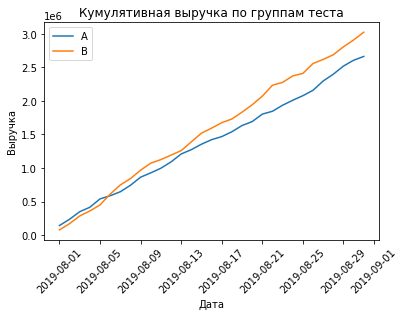

In [53]:
# График выручки группы А
plt.plot(cumulativeRevenueA_filtered['date'], cumulativeRevenueA_filtered['revenue'], label='A');

# График выручки группы B
plt.plot(cumulativeRevenueB_filtered['date'], cumulativeRevenueB_filtered['revenue'], label='B');

plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам теста')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend()
plt.show()


По графику по очищенным видно, что больше нет никаких резких скачков, но при этом кумулятивная выручка группы B выше, чем у группы A.

#### 2) Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.


Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

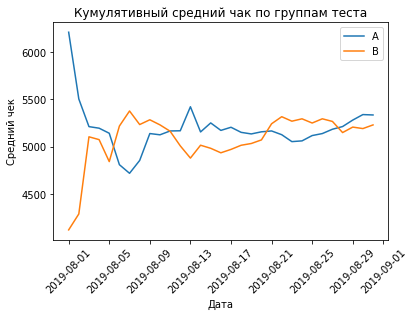

In [54]:
plt.plot(cumulativeRevenueA_filtered['date'], cumulativeRevenueA_filtered['revenue']/cumulativeRevenueA_filtered['orders'], label='A')
plt.plot(cumulativeRevenueB_filtered['date'], cumulativeRevenueB_filtered['revenue']/cumulativeRevenueB_filtered['orders'], label='B')

plt.xticks(rotation=45)
plt.title('Кумулятивный средний чак по группам теста')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()

Из графика видно, что в начале теста данные очень сильно колеблются, но также видно, что они практически зеркальные и постепенно стремятся примерно к одним и тем же значениям. Но утверждать какая из групп лучше по этим данным нельзя.

#### 3) Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.


Text(0.5, 0, 'Дата')

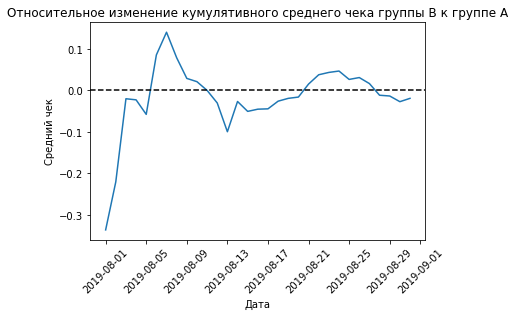

In [55]:
# собирем данные в одном датафрейме
mergedCumulativeRevenue_filtered = cumulativeRevenueA_filtered.merge(cumulativeRevenueB_filtered, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# поcтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue_filtered['date'], (mergedCumulativeRevenue_filtered['revenueB']/mergedCumulativeRevenue_filtered['ordersB'])/(mergedCumulativeRevenue_filtered['revenueA']/mergedCumulativeRevenue_filtered['ordersA'])-1)

# добавим горизонтальную ось методом axhline()
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.ylabel('Средний чек')
plt.xlabel('Дата')

Также как по сырым данным видим, что график скачет - иногда группа B лучше группы A, а иногда наоборот. То есть очистка данных никак не изменила выводов по среднему чеку.


#### 4) Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.


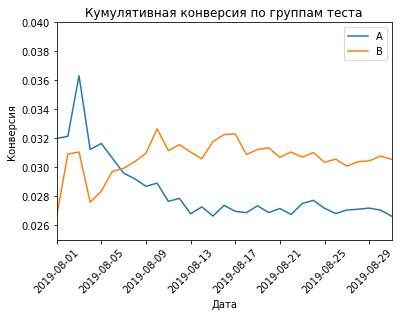

In [56]:
# посчитаем кумулятивную конверсию
cumulativeData_filtered['conversion'] = cumulativeData_filtered['orders']/cumulativeData_filtered['visitors']

# выделим данные группы A
cumulativeDataA_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='A']

# выделим данные группы B
cumulativeDataB_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='B']

# построим графики
plt.plot(cumulativeDataA_filtered['date'], cumulativeDataA_filtered['conversion'], label='A')
plt.plot(cumulativeDataB_filtered['date'], cumulativeDataB_filtered['conversion'], label='B')
plt.legend()

# зададим масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.04])

plt.xticks(rotation=45)
plt.title('Кумулятивная конверсия по группам теста')
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.legend()


Вывод такой же, как и по "сырым" данным, но конверсия стала ниже:

Из графика видно, что сначала кумулятивная конверсия в обоих группах скачет, но через некоторое время более-менее устанавливается на ппримерно 2,7 % для группы A и на 3,1% для группы B. То есть группа B показала себя лучше.

#### 5) Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.


Text(0.5, 0, 'Дата')

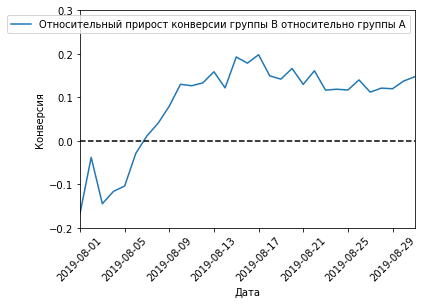

In [57]:
mergedCumulativeConversions_filtered = cumulativeDataA_filtered[['date','conversion']].merge(cumulativeDataB_filtered[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions_filtered['date'], mergedCumulativeConversions_filtered['conversionB']/mergedCumulativeConversions_filtered['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.3])

plt.xticks(rotation=45)
plt.ylabel('Конверсия')
plt.xlabel('Дата')

Вывод похож на вывод по сырым данным:

Из графика видно, что первую неделю группа B проигрывает группе A, но потом она растет и остается стабильно лучше относительно группы A на протяжении всего теста (хотя перепады все еще довольно сильные и нельзя сказать, что конверсия установилась).


## Общий вывод

1. Перед началом работы данные были предобработаны: был изменен тип данных в столбцах двух таблиц, а также был изменен регистр (на нижний) у названий столбцов таблицы orders.

2. Для приоритизации гипотез был применен фреймворки ICE и RICE, с помощью которых были выделены 5 гипотез, но в зависимости от фреймворка, их порядок немного менялся. Фреймворк ICE дал приоритетность: 8-0-7-6-2, а фреймфорк RICE дал приоритетность: 7-2-0-6-8. Я бы советовала использовать фреймворк RICE, тк он учитывает охват.

Гипотезы:
- 0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей          
- 2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа                  
- 6. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию        
- 7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок            
- 8. Запустить акцию, дающую скидку на товар в день рождения   


3. Были построены графики для конверсии, среднего чека и кумулятивной выручки, а также посчитана статистическая значимость различий в среднем чеке и в конверии между группами по "сырым" и по чистым данным. 
И сделаны выводы:
- Есть статистически значимое различие по конверсии между группами и по «сырым» и по данным после фильтрации аномалий. Относительный выйгрыш группы B равен в сырых данных равен 13%, а в отфильтрованных - 14%.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий, а отношение среднего чека группы B к группе A очень сильно колеблется (в "сырых" данных дает положительный результат, а в очищенных - отрицательный).
    
Но тк выручка магазина складывается из конверсии и среднего чека, а в конверсии мы нашли статистически значимое различие между группой B и группой A, то можно посмотреть еще раз на график кумулятивной выручки по группам (по очищенным данным), по которому видно, что группа B выигрывает по кумулятивной выручке у группы A.    
    
Исходя из обнаруженных фактов, тест следует остановить и признать выгрыш группы B.    